**1. Data wrangling**

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
# Load data from CSV
tx_df = pd.read_csv('int_online_tx.csv')

In [3]:
# Only keep transactions with CustomerID's
clean_tx_df = tx_df[tx_df.CustomerID.notnull()].copy()

# Convert customer ID's into integers
clean_tx_df['CustomerID'] = clean_tx_df.CustomerID.astype(int)

# Create 'Sales'
clean_tx_df['Sales'] = clean_tx_df.Quantity * clean_tx_df.UnitPrice

In [4]:
# Aggegrate invoice data
invoice_data = clean_tx_df.groupby('CustomerID').InvoiceNo.agg(['nunique'])
invoice_data.columns = ['total_transactions']

In [5]:
# Aggregate cart-level data (at invoice level)
cart_data = clean_tx_df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg(['sum'])
cart_data.columns = ['cart_value']

# Reset index
cart_data.reset_index(inplace=True)

In [6]:
clean_tx_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6


In [7]:
# Check the number of missing values
clean_tx_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [8]:
# Save cleaned transaction level data
clean_tx_df.to_csv('cleaned_transactions.csv', index=None)

In [9]:
# Check the mean number of transactions
invoice_data.total_transactions.mean()


3.710144927536232

In [10]:
# and average cart data value
cart_data.cart_value.mean()

609.8249414062499

Transaction level exploration: check the shape and quality od data and see transaction distribution by country

In [11]:
# Check datafarme dimensions
clean_tx_df.shape

(33698, 9)

In [12]:
# First 10 rows of data
clean_tx_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583,France,40.8
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583,France,30.0
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583,France,53.1
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583,France,70.8
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583,France,46.8


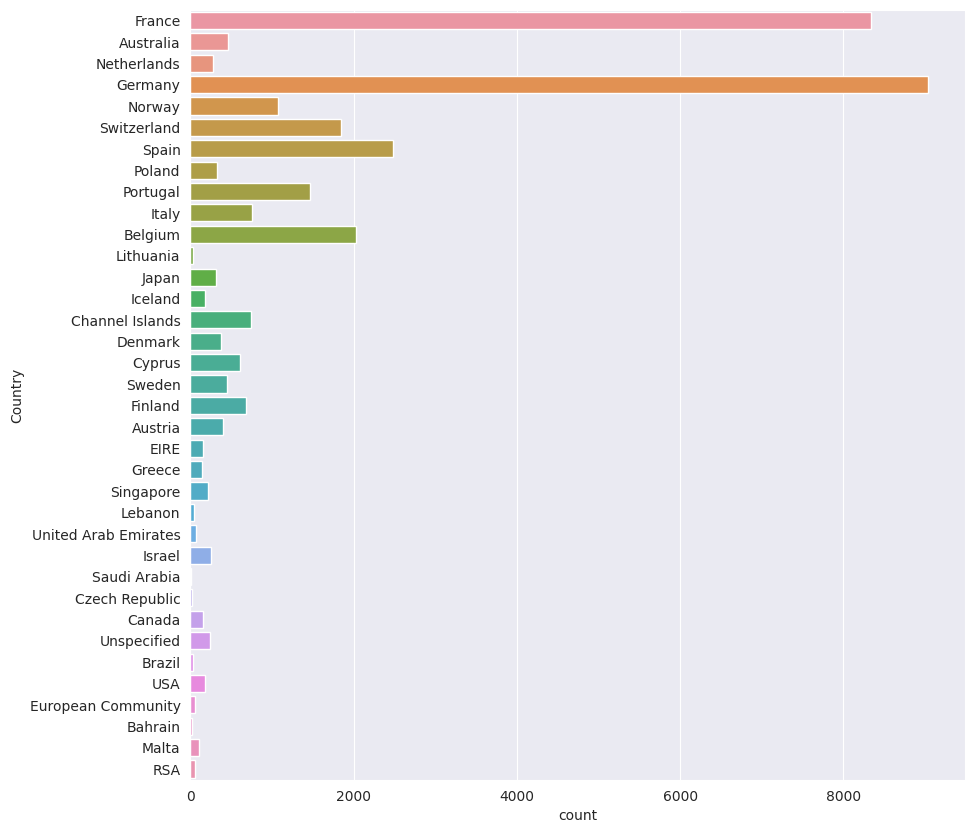

In [13]:
# Make figsize 10x10
plt.figure(figsize=(10,10))

# Bar plot by country
sns.countplot(y='Country', data=clean_tx_df)
plt.show()

We can see that many countries have very sparce classes at the transaction level, which wouldbe even sparcer at customer level since there could be multiple transactons per customer. Clustering by country in this case might not be very efficient.

Customer level aggregation

In [14]:
# Aggregate product data
product_data = clean_tx_df.groupby('CustomerID').StockCode.agg( ['count', 'nunique'] )
product_data.columns = ['total_products', 'total_unique_products']

In [15]:
# Display product data for first 5 customers
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


In [16]:
# Check that for every case total_unique_products is less than total_products
all(product_data.total_products >= product_data.total_unique_products)

True

In [17]:
# Create 2 features: Total sales per customer and average vule of the products by customer
# Roll up sales data
sales_data = clean_tx_df.groupby('CustomerID').Sales.agg( ['sum', 'mean'] )
sales_data.columns = ['total_sales', 'avg_product_value']

# Display sales data for first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


In [18]:
# Customer level cart data
cart_data.head()

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


In [19]:
# Aggregate cart data per customer, create 3 features: average,min and max
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg(['mean', 'min', 'max'])
agg_cart_data.columns = ['avg_cart_value','min_cart_value','max_cart_value']

# Check data
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


In [20]:
# Join all the customer level datasets and check the output
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [21]:
# Save the final base table
customer_df.to_csv('analytical_base_table.csv')